In [249]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv('FoodFacts.csv')

//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,3,5,27,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
df.columns[[0, 3, 5, 27, 36]]

Index(['code', 'created_t', 'last_modified_t', 'cities', 'allergens_en'], dtype='object')

In [33]:
# Don't need code column
df.drop(['code', 'created_t', 'last_modified_datetime'], axis=1, inplace=True)

In [26]:
df.dtypes

code                                 object
url                                  object
creator                              object
created_t                            object
created_datetime                     object
last_modified_t                      object
last_modified_datetime               object
product_name                         object
generic_name                         object
quantity                             object
packaging                            object
packaging_tags                       object
brands                               object
brands_tags                          object
categories                           object
categories_tags                      object
categories_en                        object
origins                              object
origins_tags                         object
manufacturing_places                 object
manufacturing_places_tags            object
labels                               object
labels_tags                     

In [86]:

#https://www.kaggle.com/christinampoid/d/openfoodfacts/world-food-facts/europe-habits

#labels: list of Strings with country names
#returns the rows that have as country name any of the names in labels
def get_rows_country(labels):
    return df[df.countries.isin(labels)]

#labels: list of Strings with country names
#returns the categories and the percentage that appear in the rows of a particular country
def get_categories_counts(labels):
    rows = get_rows_country(labels)
    food_country = rows.main_category_en.value_counts() / len(rows)*100
    return food_country

#France
labels_france = ['France', 'en:FR', 'France,Europe','Belgique,France']
french_food = get_rows_country(labels_france)

#Spain
labels_spain = ['España','en:ES','Espagne','Spain']
spanish_food = get_rows_country(labels_spain)

#Germany
labels_germany = ['Deutschland','Germany','Allemagne','en:DE']
german_food = get_rows_country(labels_germany)

#United Kingdom
labels_uk = ['en:UK','United Kingdom','en:GB','uk','UK']
uk_food = get_rows_country(labels_uk)

#Belgium
labels_belgium = ['Belgique','en:BE','Belgique,France','Belgium','Belgique,France']
belgium_food = get_rows_country(labels_belgium)

#Italia
labels_italia = ['Italia','en:IT','Italie']
italian_food = get_rows_country(labels_italia)

#Switzerland
labels_switzerland = ['Suisse','Switzerland']
suisse_food = get_rows_country(labels_switzerland)

#Netherlands
labels_netherlands = ['Netherlands', 'Holland']
holland_food = get_rows_country(labels_netherlands)

#Denmark
labels_denmark = ['Denmark','Dänemark']
dannish_food = get_rows_country(labels_denmark)

#Portugal
labels_portugal = ['Portugal','en:portugal']
portuguese_food = get_rows_country(labels_portugal)

#Greece
labels_greece = ['Greece','en:GR','Grèce','en:greece']
greek_food = get_rows_country(labels_greece)

#Sweden
labels_sweden = ['Sweden','en:SE','en:sweden']
swedish_food = get_rows_country(labels_sweden)

#Norway
labels_norway = ['Norway','en:NO','en:norway']
norwegian_food = get_rows_country(labels_norway)

#Croatia
labels_croatia = ['Croatia','en:HR','en:croatia']
croatian_food = get_rows_country(labels_croatia)

#Albania
labels_albania = ['Albania','en:AL','en:albania']
albanian_food = get_rows_country(labels_albania)

labels_usa = ['United States', 'en:US', 'US', 'USA', 'en:united-states','United states', 'united states', 'United States of America']
usa = get_rows_country(labels_usa)

In [53]:
europe = pd.concat([french_food,
                    spanish_food,
                    german_food, 
                    uk_food, 
                    belgium_food, 
                    italian_food, 
                    suisse_food,
                    holland_food,
                    dannish_food, 
                    portuguese_food, 
                    greek_food, 
                    swedish_food,
                    norwegian_food,
                    croatian_food, 
                    albanian_food])

In [88]:
mask = df.countries.str.contains('US', na=False)
df[mask].countries.unique()

array(['en:US', 'US', 'USA', 'France,USA', 'Germany,USA,UK'], dtype=object)

In [176]:
usaNumOnly = usa.select_dtypes(include=[np.number])
europeNumOnly = europe.select_dtypes(include=[np.number])

In [177]:
usaMeans = usaNumOnly.mean()
usaNaCols  = usaMeans[usaMeans.isnull() == True].index.tolist()

euroMeans = europeNumOnly.mean()
euroNaCols  = euroMeans[euroMeans.isnull() == True].index.tolist()
combinedNaCols = usaNaCols + euroNaCols
#usaNumOnly.columns[usaNumOnly.mean().isnull().astype(int).values]

In [178]:
usaNumOnly = usaNumOnly.drop(combinedNaCols, axis=1)
europeNumOnly = europeNumOnly.drop(combinedNaCols, axis=1)
print(europeNumOnly.shape)
print(usaNumOnly.shape)

(55942, 53)
(2413, 53)


In [198]:
usaNumOnly['isEuro'] = 0
europeNumOnly['isEuro'] = 1
train = pd.concat([usaNumOnly, europeNumOnly])

In [199]:
train = train.fillna(0, axis=0)

In [200]:
train.head()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,energy_from_fat_100g,fat_100g,saturated_fat_100g,monounsaturated_fat_100g,polyunsaturated_fat_100g,omega_3_fat_100g,...,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,fruits_vegetables_nuts_100g,cocoa_100g,carbon_footprint_100g,nutrition_score_fr_100g,nutrition_score_uk_100g,isEuro
20,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
56,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
78,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
83,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
87,3.0,0.0,0.0,761.0,275.0,7.58,4.04,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0


### Fit various models to assess the predictive power of each ingredient in distinguishing Euro foods from USA foods

In [339]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
X = train.drop('isEuro', axis= 1).values
y = train['isEuro'].values

In [340]:
clf.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [341]:
coef_df = pd.DataFrame({'value': clf.coef_[0], 'feature': train.drop('isEuro', axis=1).columns })

In [342]:
coef_df['absVal'] = abs(coef_df['value'])
coef_df.sort_values(by='absVal', ascending=False, inplace=True)
coef_df.iloc[0:10, :]

,feature,value,absVal
1,ingredients_from_palm_oil_n,2.141927,2.141927
2,ingredients_that_may_be_from_palm_oil_n,1.716385,1.716385
12,cholesterol_100g,-0.843868,0.843868
9,omega_3_fat_100g,0.633228,0.633228
31,vitamin_b9_100g,-0.435120,0.435120
40,zinc_100g,-0.434366,0.434366
15,lactose_100g,0.213532,0.213532
10,alpha_linolenic_acid_100g,0.195304,0.195304
52,nutrition_score_uk_100g,-0.136866,0.136866
32,vitamin_b12_100g,-0.131708,0.131708


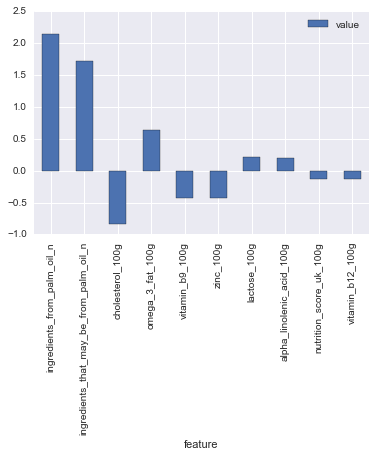

In [343]:
coef_df.iloc[0:10, :].plot(kind='bar', x='feature', y='value')

It seems like many palm oil may indicate that a product is European. But that doesn't mean that European products are more likely to contain it than US products. In Europe, palm oil is required on food labels. In the US, it isn't:

- https://www.theguardian.com/sustainable-business/2014/dec/12/eu-labelling-changes-palm-oil-consumer-change
- http://www.eurofoodlaw.com/labelling/analysis-palm-oil-no-longer-a-hidden-ingredient-108325.htm


Now let's try a random forest.

In [344]:
from sklearn.ensemble import RandomForestClassifier as rf
clf = rf(max_depth=5)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [345]:
importances_df = pd.DataFrame({'value': clf.feature_importances_, 'feature': train.drop('isEuro', axis=1).columns})
importances_df.sort_values(by='value', inplace=True, ascending=False)

In [346]:
importances_df.iloc[0:10, :]

,feature,value
4,energy_from_fat_100g,0.248573
38,iron_100g,0.142917
36,calcium_100g,0.138129
12,cholesterol_100g,0.125114
22,vitamin_a_100g,0.069606
5,fat_100g,0.032353
19,salt_100g,0.030007
18,proteins_100g,0.026617
26,vitamin_c_100g,0.022783
35,potassium_100g,0.019535


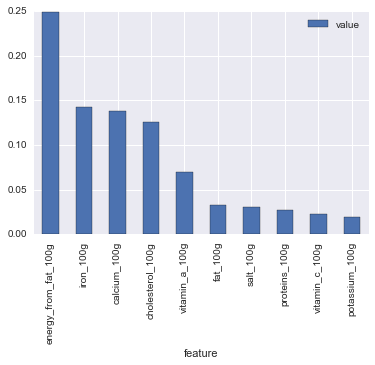

In [347]:
importances_df.iloc[0:10, :].plot(kind='bar', x='feature', y='value')

hmm..it looks like palm oil isn't very important to our random forest. Let's remove palm oil, and see what happes

In [348]:
clf = LogisticRegression()
X = train.drop(['isEuro', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n'], axis= 1).values
y = train['isEuro'].values
clf.fit(X,y)
coef_wo_palm_df = pd.DataFrame({'value': clf.coef_[0], 
                        'feature': train.drop(['isEuro', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n'], 
                                              axis= 1).columns })
coef_wo_palm_df['absVal'] = abs(coef_wo_palm_df['value'])
coef_wo_palm_df.sort_values(by='absVal', ascending=False, inplace=True)
coef_wo_palm_df.iloc[0:10, :]

,feature,value,absVal
7,omega_3_fat_100g,0.282852,0.282852
10,cholesterol_100g,-0.202073,0.202073
38,zinc_100g,-0.141330,0.141330
29,vitamin_b9_100g,-0.141246,0.141246
50,nutrition_score_uk_100g,-0.126176,0.126176
8,alpha_linolenic_acid_100g,0.118696,0.118696
49,nutrition_score_fr_100g,0.101988,0.101988
30,vitamin_b12_100g,-0.095458,0.095458
0,additives_n,0.082683,0.082683
6,polyunsaturated_fat_100g,-0.081482,0.081482


In [349]:
from sklearn.ensemble import RandomForestClassifier as rf
clf = rf(max_depth=5)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [350]:
importances_wo_palm_df = pd.DataFrame({'value': clf.feature_importances_[0], 
                        'feature': train.drop(['isEuro', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n'], 
                                              axis= 1).columns })
importances_wo_palm_df['absVal'] = abs(importances_wo_palm_df['value'])
importances_wo_palm_df.sort_values(by='absVal', inplace=True, ascending=False)
importances_wo_palm_df

,feature,value,absVal
0,additives_n,0.004193,0.004193
38,zinc_100g,0.004193,0.004193
28,vitamin_b6_100g,0.004193,0.004193
29,vitamin_b9_100g,0.004193,0.004193
30,vitamin_b12_100g,0.004193,0.004193
31,biotin_100g,0.004193,0.004193
32,pantothenic_acid_100g,0.004193,0.004193
33,potassium_100g,0.004193,0.004193
34,calcium_100g,0.004193,0.004193
35,phosphorus_100g,0.004193,0.004193


Without palm oil, the random forest has gone haywire

Let's look at correlation coeffiecients.

In [365]:
corr_df = pd.DataFrame({'feature': [], 'pval': [], 'value': []})

from scipy.stats import pointbiserialr
X = train.drop(['isEuro'], axis= 1).values
y = train['isEuro'].values

for col in train.drop(['isEuro'], axis= 1).columns:
    corr = pointbiserialr(train['isEuro'].values, train[col].values)
    corr_df = corr_df.append(pd.Series({'feature': col, 'pval':corr.pvalue, 'value': corr.correlation}), ignore_index=True)

corr_df

,feature,pval,value
0,additives_n,4.724936e-14,0.031203
1,ingredients_from_palm_oil_n,7.369269e-24,0.041676
2,ingredients_that_may_be_from_palm_oil_n,1.257972e-31,0.048411
3,energy_100g,6.879534e-07,0.020550
4,energy_from_fat_100g,0.000000e+00,-0.340279
5,fat_100g,9.603702e-05,0.016145
6,saturated_fat_100g,5.373524e-04,0.014329
7,monounsaturated_fat_100g,2.127616e-02,-0.009534
8,polyunsaturated_fat_100g,1.836239e-09,-0.024883
9,omega_3_fat_100g,7.977757e-03,0.010982
